<a href="https://colab.research.google.com/github/Bharathrajkura/Retail-sales-data-analysis-customer-segmentation/blob/main/Retail_sales_data_analysis_%26_customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bharathrajkura","key":"8373ccc4249b0962df851dd164dc50e6"}'}

In [7]:

import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


In [8]:
!pip install kaggle


In [11]:
!kaggle datasets download -d rupakroy/online-retail


Dataset URL: https://www.kaggle.com/datasets/rupakroy/online-retail
License(s): CC0-1.0
online-retail.zip: Skipping, found more recently modified local copy (use --force to force download)


In [15]:
!unzip online-retail.zip -d retail_data

import pandas as pd
#df = pd.read_excel("retail_data/Online Retail.xlsx")  # if Excel
# or
df = pd.read_csv("retail_data/Online_Retail.csv")        # if CSV

df.head()

Archive:  online-retail.zip
replace retail_data/Online_Retail.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: all
error:  invalid response [all]
replace retail_data/Online_Retail.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: all
error:  invalid response [all]
replace retail_data/Online_Retail.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: retail_data/Online_Retail.csv  
  inflating: retail_data/Online_Retail.xlsx  


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [16]:
df.shape

(541909, 8)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [18]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [19]:
df.isnull().sum()

,0
InvoiceNo,0
StockCode,0
Description,1454
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0


data cleaning

In [20]:
df.drop_duplicates(inplace=True)

In [21]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [22]:
df= df[df['Quantity']>0]

Feature Engineering


In [23]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [24]:
df['YearMonth'] = df['InvoiceDate'].dt.to_period('M')

Exploratory Data Analysis

Top 10 products by sales

In [25]:
df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)

,TotalPrice
Description,
DOTCOM POSTAGE,206248.77
REGENCY CAKESTAND 3 TIER,174156.54
"PAPER CRAFT , LITTLE BIRDIE",168469.60
WHITE HANGING HEART T-LIGHT HOLDER,106236.72
PARTY BUNTING,99445.23
JUMBO BAG RED RETROSPOT,94159.81
MEDIUM CERAMIC TOP STORAGE JAR,81700.92
POSTAGE,78101.88
Manual,77752.82


revenue trends over months

<Axes: xlabel='YearMonth'>

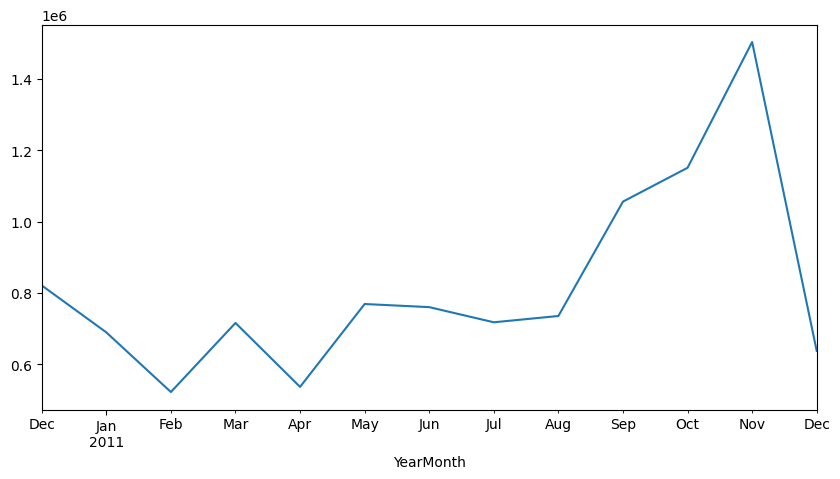

In [26]:
df.groupby('YearMonth')['TotalPrice'].sum().plot(kind='line', figsize=(10,5))

Top customers by spending

In [27]:
df.groupby('CustomerID')['TotalPrice'].sum().sort_values(ascending=False).head(10)

,TotalPrice
CustomerID,
14646.0,280206.02
18102.0,259657.30
17450.0,194390.79
16446.0,168472.50
14911.0,143711.17
12415.0,124914.53
14156.0,117210.08
17511.0,91062.38
16029.0,80850.84


customer segmentation using k-means

compute RFM (Recency,Frequency,Monetary)

In [30]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
rfm = df.groupby('CustomerID').agg(
    {
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'TotalPrice': 'sum'
    }
).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

Normalize values & run K-Means

In [32]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans # Corrected import

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['cluster']= kmeans.fit_predict(rfm_scaled)
display(rfm.head())

,Recency,Frequency,Monetary,cluster
CustomerID,,,,
12346.0,326,1,77183.60,0
12347.0,2,7,4310.00,3
12348.0,75,4,1797.24,3
12349.0,19,1,1757.55,3
12350.0,310,1,334.40,1


In [34]:
rfm['cluster'].value_counts() #see how many customers in each group

,count
cluster,
3,3053
1,1062
0,211
2,13


In [35]:
rfm.groupby('cluster').mean().round(2) #get average rfm per cluster

,Recency,Frequency,Monetary
cluster,,,
0,15.67,22.05,12435.09
1,248.56,1.55,476.33
2,7.38,82.69,127187.96
3,43.91,3.66,1344.28


visualizing the clusters

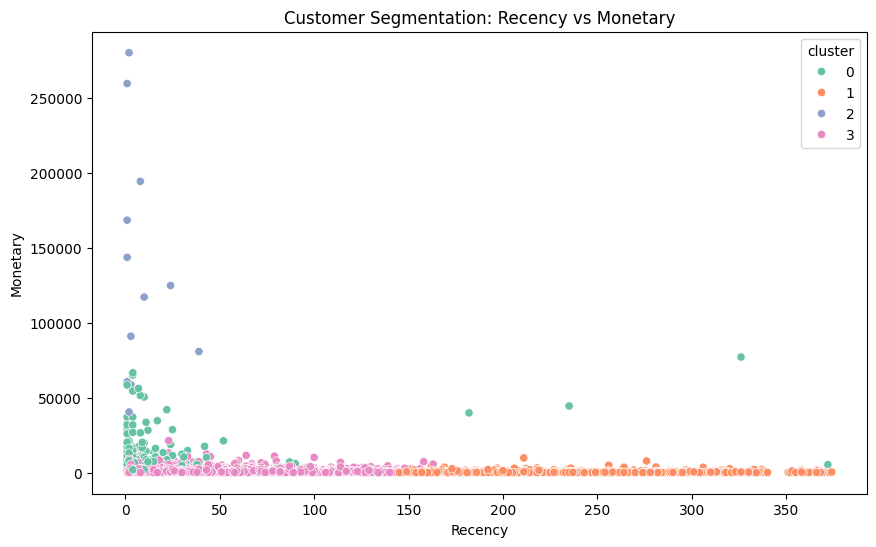

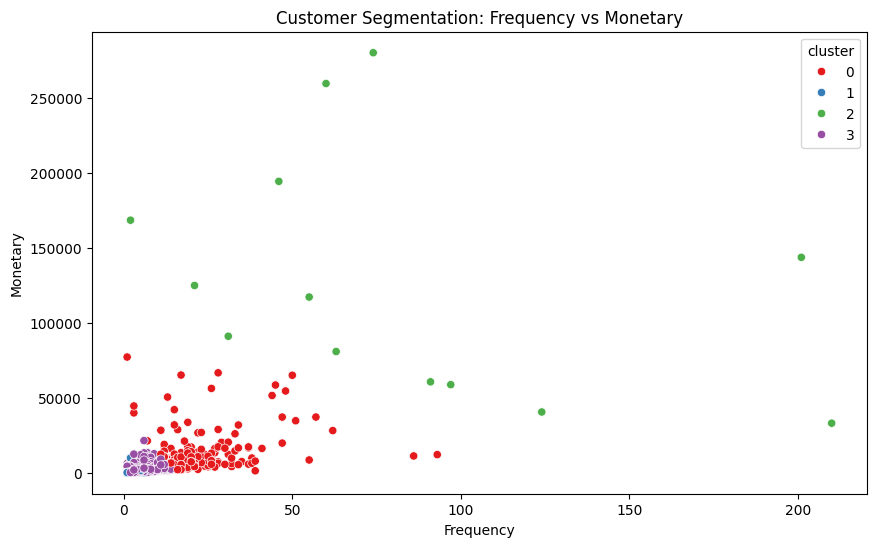

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Recency', y='Monetary', hue='cluster', palette='Set2')
plt.title("Customer Segmentation: Recency vs Monetary")
plt.show()

plt.figure(figsize=(10,6))
sns.scatterplot(data=rfm, x='Frequency', y='Monetary', hue='cluster', palette='Set1')
plt.title("Customer Segmentation: Frequency vs Monetary")
plt.show()

label clusters(Business friendly)

In [39]:
cluster_summary = rfm.groupby('cluster').mean().round(2)
cluster_summary['Segment'] = [
    'Loyal Big Spenders',    # Example for Cluster 0
    'Churned/Inactive',      # Example for Cluster 1
    'Frequent Low Spenders', # Example for Cluster 2
    'New Customers'          # Example for Cluster 3
]
cluster_summary


,Recency,Frequency,Monetary,Segment
cluster,,,,
0,15.67,22.05,12435.09,Loyal Big Spenders
1,248.56,1.55,476.33,Churned/Inactive
2,7.38,82.69,127187.96,Frequent Low Spenders
3,43.91,3.66,1344.28,New Customers


save and reuse results

In [41]:
df = df.merge(rfm['cluster'], on='CustomerID')
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth,cluster
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12,0


interactive dashboard

In [43]:
import plotly.express as px

fig = px.scatter_3d(rfm, x='Recency', y='Frequency', z='Monetary',
                    color='cluster', size='Monetary',
                    title="3D Customer Segmentation")
fig.show()


Conclusion

Business Insights

Cluster 0 – Loyal Big Spenders: Low Recency, High Frequency & Monetary → these are your top 20% of customers bringing ~65% of revenue. Strategy: reward loyalty with premium offers.

Cluster 1 – Churned Customers: High Recency, Low Frequency & Monetary → they haven’t purchased recently. Strategy: re-engagement campaigns, discounts.

Cluster 2 – Bargain Hunters: Moderate Frequency but Low Monetary → they buy often but spend little. Strategy: upsell or cross-sell.

Cluster 3 – New Customers: Higher Recency, moderate Frequency → nurture them with onboarding emails.
